In [1]:
import numpy as np
import pandas as pd
import pcreode
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings( 'ignore')

In [2]:
def get_data( fact):
    # get curved trajectory 
    a = 25
    b = 20
    x0 = 12
    y0 = 0
    bot = np.arange(-math.pi, -math.pi/4.0, (math.pi - math.pi/4.0)/(500*fact)) + np.random.uniform( -0.006, 0.006, 500*fact)
    x_ep = x0 + a*np.cos( bot) + np.random.uniform( -2.0, 2.0, len(bot))
    y_ep = y0 + b*np.sin( bot) + np.random.uniform( -2.0, 2.0, len(bot))
    
    # get center linear trajectory
    n_end_points = 750
    x_l = np.random.uniform(-30.0, 15.0, n_end_points)
    y_l = np.random.uniform( -1.8,  1.8, n_end_points)
    
    # bot linear branch
    x_bot = np.random.uniform( 15, 40, n_end_points)
    y_bot = (-4/5.0)*x_bot + 12 + np.random.uniform( -2.0, 2.0, len(x_bot))

    # top linear branch
    x_top = np.random.uniform( 15, 40, n_end_points)
    y_top = (4/5.0)*x_top + -12 + np.random.uniform( -2.0, 2.0, len(x_top))
    
    # mid linear branch
    x_mid = np.random.uniform( 0, 12, n_end_points)
    y_mid = (7/5.0)*x_mid + 0 + np.random.uniform( -2.2, 2.2, len(x_mid))
    
    x = np.append( x_ep, [x_l, x_bot, x_top, x_mid])
    y = np.append( y_ep, [y_l, y_bot, y_top, y_mid])
    
    return( np.transpose( np.vstack( [x,y])))

In [3]:
data = get_data( 2)

((-40, 50), (-40, 50))

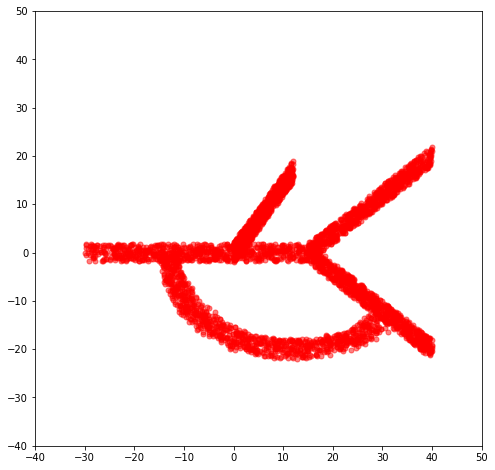

In [4]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = 'r'
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlim(-40,50), ax1.set_ylim(-40,50)

best guess starting radius = 0.721397595626


0.7213975956259889

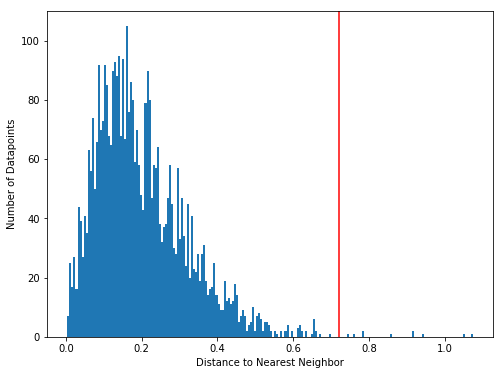

In [5]:
dens = pcreode.Density( data)
dens.nearest_neighbor_hist()

calculating densities for datapoints: 0 -> 3999
****Always check density overlay for radius fit****


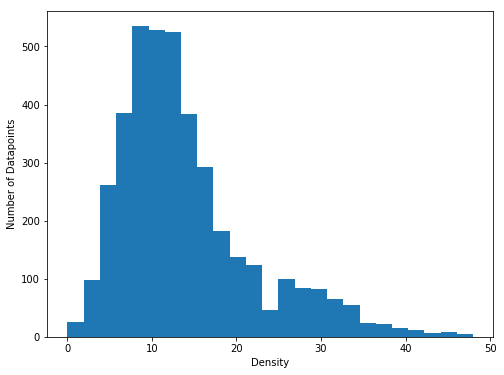

In [6]:
density = dens.get_density( radius=0.80)
dens.density_hist( n_bins=25)

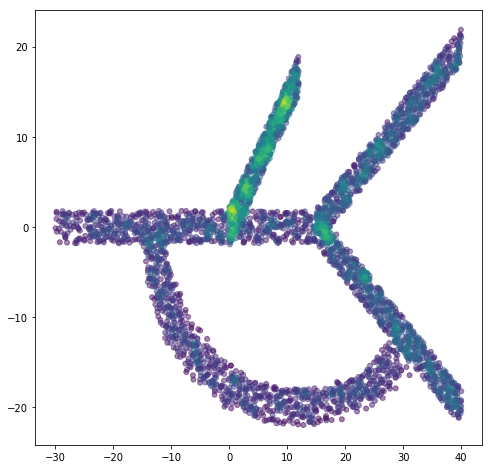

In [7]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = density
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)

In [8]:
noise  = 0.0
target = 5.0

In [9]:
downed, downed_ind = pcreode.Down_Sample( data, density, noise, target)

Number of data points in downsample = 1494


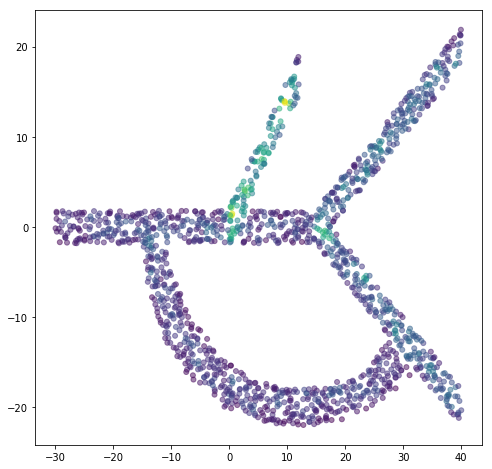

In [10]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = density[downed_ind]
ax1.scatter( downed[:,0], downed[:,1], alpha=0.5, s=25, c=cc)

In [11]:
data = get_data( 2)
endstates_ind, down_ind, clust_ids, std_cls = pcreode.find_endstates( data, density, noise, target, potential_clusters=10, cls_thresh=-1.0)

Number of data points in downsample = 1578
Constructing density kNN
finding endstates
Number of endstates found -> 8


(-30, 30)

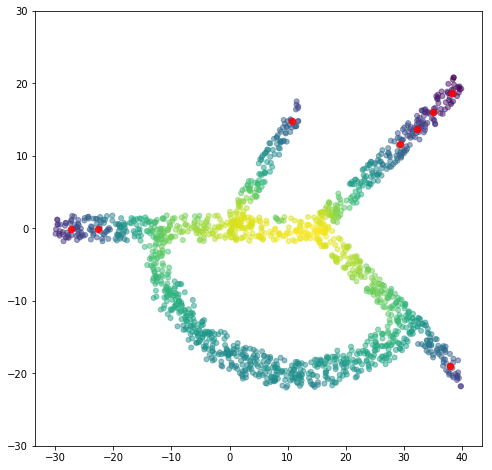

In [12]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[endstates_ind,0], data[endstates_ind,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

In [13]:
file_path = "../test/"

In [14]:
out_graph, out_ids = pcreode.pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)

Performing 1 independent runs, may take some time
Number of data points in downsample = 1574
Constructing density kNN
finding endstates
Number of endstates found -> 8
hierarchical placing
consensus aligning
saving files for run_num 1


(-30, 30)

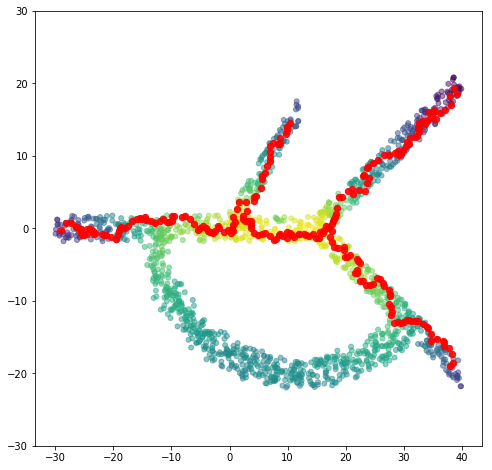

In [15]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

(-30, 30)

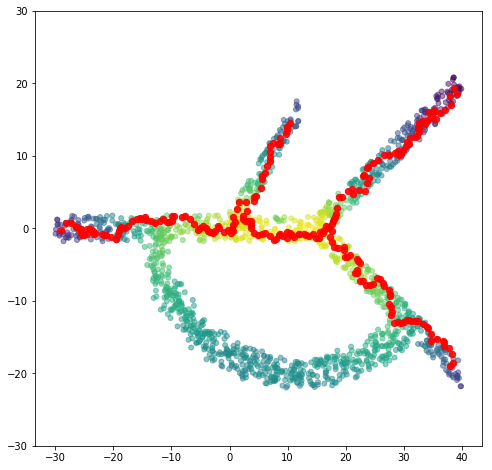

In [16]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

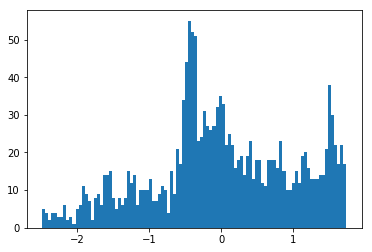

In [17]:
_ = plt.hist( std_cls, bins=100)

In [18]:
import igraph as _igraph
import matplotlib.pyplot as _plt
import random
from igraph import *
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans as _KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import os as _os

In [19]:
def pCreode( data, density, noise, target, file_path, num_runs=100, potential_clusters=10, cls_thresh=0.0, start_id=0, mute=False):
    ''' 
    Function for running full pCreode algorithm, with the addition of principle component extremes found to be under the closeness threshold added as endstates
    :param data:    numpy ndarray of data set
    :param density: numpy array of calculated densities for each datapoint
    :param noise:   value for noise threshold, densities below value will be removed during downsampling
    :param target:  value for target density
    :param file_path: path to directory where output files will be stored
    :param num_runs:  number of independent runs to perform, default is 100 
    :param potential_clusters: value for upper range of number of clusters to search for, default value is 10
    :param cls_thresh: value for closeness threshold use to separate potential endstates from transitional cell types default value is 0.0
    :param start_id: integer at which to start labeling output graphs, allows for addition of graphs to previously ran lot
    :param  mute: boolean operator to suppress print statements
    :return: will save creode files in given directory
    '''
    if not ( isinstance( data, np.ndarray)):
        raise TypeError( 'data variable must be numpy ndarray')
    if not ( isinstance( density, np.ndarray)):
        raise TypeError( 'data variable must be numpy array')
    if not ( _os.path.exists( file_path)):
        raise TypeError( 'please supply a valid directory')
        
    # Save sys.stdout to return print output if muted 
    old_stdout = sys.stdout
    # Mute print statements if True
    if( mute==True):
        sys.stdout = open( os.devnull, 'w')
        
    print( "Performing {0} independent runs, may take some time".format( num_runs))
  
    for run_itr in range( num_runs):
        
        # get downsampled dataset
        down, down_ind = pcreode.Down_Sample( data, density, noise, target)

        # array for orginal density (prior to downsampling) of downsampled data points
        down_density = density[down_ind]
        n_down       = len( down)

        # get distance matrix for down sampled dataset
        Dist = np.array( pairwise_distances( down, down, n_jobs=1))

        # set upper and lower thresholds for number of neighbors to connect in density 
        # based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
        upper_nn = 25
        lower_nn = 2

        # assign number of neighbors to connect to, to each datapoint 
        sorted_nn = np.linspace( lower_nn, upper_nn, n_down, dtype=int)
        nn = np.zeros( n_down, dtype=int)
        nn[np.argsort( down_density)] = sorted_nn

        # create adjacency matrix to hold neighbor connections for d-kNN
        knn_adj = np.zeros( ( n_down, n_down), dtype=int)
        for zz in range( n_down):
            knn_adj[zz,np.argsort( Dist[zz,:])[1:nn[zz]]] = 1
        # to make symetric add adj with transpose
        knn_adj = np.add( knn_adj, knn_adj.T)
        
        # make sure there is only one component by constructing a MST
        Dist_csr = csr_matrix( np.triu(Dist))
        Tcsr     = minimum_spanning_tree( Dist_csr)
        mst_adj  = pd.DataFrame( Tcsr.todense()).values
        mst_adj  = np.add( mst_adj, mst_adj.T)
        
        # add the two adjacency matrices
        adj = np.add( knn_adj, mst_adj)
        
        # make sure overlaping neighbors arnt double counted
        adj[adj>0] = 1.0

        # normalize the orginal densities of the downsampled data points
        norm = preprocessing.MinMaxScaler()
        dens_norm = np.ravel( norm.fit_transform( down_density.reshape( -1, 1).astype( np.float)))

        # weight edges of d-kNN by inverse of orginal densities
        den_adj = np.zeros( ( n_down, n_down), dtype=float)
        print( "Constructing density kNN")
        # get coordinates of connections from adjacency matrix
        adj_coords = np.nonzero( np.triu( adj))
        for hh, uu in zip( adj_coords[0], adj_coords[1]):
            # take the minimum density of nodes connected by the edge
            # add 0.1 so that no connection is lost (not equal to zero)
            den_adj[hh,uu] = 1.1 - ( min( [dens_norm[hh], dens_norm[uu]]))
        # make symetric 
        den_adj  = np.add( den_adj, den_adj.T)
        # final edge weights are product of density weights and distance matrix
        dist_weighted_adj = np.multiply( Dist, adj)
        dens_weighted_adj = np.multiply( Dist, den_adj)
        # create undirected igraph instance using weighted matrix
        d_knn = _igraph.Graph.Weighted_Adjacency( dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

        print( "finding endstates")
        # get closeness of graph and standardize to aid in endstate identification
        cls     = np.array( d_knn.closeness( weights="weight"))
        scaler  = preprocessing.StandardScaler()
        std_cls = scaler.fit_transform( cls.reshape(-1,1)).ravel()

        # using closeness as threshold (default value = 0.0) get potential endstates
        low_cls = down[std_cls<=cls_thresh]
        # array to hold silhouette score for each cluster try
        sil_score = [0]*potential_clusters

        # prefrom K means clustering and score each attempt
        for ss in range( potential_clusters):
            kmeans_model  = _KMeans( n_clusters=ss+2, random_state=10).fit( low_cls)
            label         = kmeans_model.labels_
            sil_score[ss] = metrics.silhouette_score( low_cls, labels=label, metric='l2')

        # find most likely number of clusters from scores above and double to allow for rare cell types
        num_clusters = ( np.argmax( sil_score) + 2)# * 2
        clust_model = _KMeans( n_clusters=num_clusters, random_state=10).fit( low_cls)
        label      = clust_model.labels_
        print( "Number of endstates found -> {0}".format( num_clusters))

        endstates = clust_model.cluster_centers_
        endstates_ind = np.zeros( (num_clusters, 1), dtype=int)
        for ii in range( num_clusters):
            endstates_ind[ii] = pcreode.find_closest_ind( endstates[ii], down)
        
        endstates_ind = endstates_ind.ravel()
        endstates = data[endstates_ind,:]
        num_clusters = len( endstates_ind)
        cen_ind = endstates_ind
        '''
        # Endstate data points were picked from full data set, so need to be appended to down and down_ind
        # Create array to hold where end_states are located within the downsampled dataset
        cen_ind = np.zeros( num_clusters, dtype=int)
        ind = n_down
        for es in range( num_clusters):
            # first need to check if they are already in the graph, if not:
            if( ~np.in1d( endstates_ind[es], down_ind)):
                down     = np.vstack( ( down, endstates[es]))
                down_ind = np.append( down_ind, endstates_ind[es])
                cen_ind[es] = ind
                ind = ind + 1
            # if data point is already in down
            else:
                cen_ind[es] = np.argwhere( endstates_ind[es]==down_ind).ravel()[0]
                continue
        '''
        # re-initialize using density and distance weighted edges         
        dens_knn = _igraph.Graph.Weighted_Adjacency( dens_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)
        '''
        # add endstate data points to the already constructed dens_knn graph, connecting to 2 closest neighbors
        # future update will so that number of edges is based on density of data point
        knn_num = 5
        # add nodes to graph that will represent endstates
        dens_knn.add_vertices( num_clusters)
        d_knn.add_vertices( num_clusters)
        # get distance matrix to be used for finding closeset neighbors in graph
        end_dist = np.array( pairwise_distances( endstates, down[:-num_clusters], n_jobs=1))
        for kk in range( num_clusters):
            edg_wts = np.sort( end_dist[kk,:])[1:knn_num+1]
            edg_ids = np.argsort( end_dist[kk,:])[1:knn_num+1]
            for jj in range( knn_num):
                # no need to connect if connection is already present
                if( edg_wts[jj]<2.0e-06):
                    continue
                # if not present add edge with distance/density weight
                else:
                    dens_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj]*(1-dens_norm[edg_ids[jj]]))
                    d_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj])
        '''            
        print( "hierarchical placing")
        # perform hierarchical placement of endstates (find shortest paths connecting them within d_knn)
        hi_pl, hi_pl_ind = pcreode.hierarchical_placement( dens_knn, cen_ind)
        print( "consensus aligning")
        # perform consensus alignment of hierarchical placement data points
        aligned_ind = pcreode.consensus_alignment( down, hi_pl_ind.copy(), data, density, noise)
        # add orginal endstates back into aligned list of indices 
        al_es_ind = np.append( cen_ind, np.unique( aligned_ind[~np.in1d( aligned_ind, cen_ind)]))
        # perform hierarchical placement of of newly aligned data points
        al_hi_pl, al_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, al_es_ind)
        # rerun hierarchical placement on the aligned placement graph to eliminate superfluous edges
        # by re-feeding it the orginal endstate indices
        creode_graph, creode_ind = pcreode.hierarchical_placement( al_hi_pl, range( len( cen_ind)))
        creode_graph.simplify( combine_edges="mean")
        print( "saving files for run_num {0}".format( run_itr + 1))
        np.savetxt( file_path + "ind_{0}.csv".format( start_id), down_ind[al_hi_pl_ind[creode_ind]], delimiter=',')
        creode_graph.save( file_path + "adj_{0}.txt".format( start_id), format="adjacency" )
        
        start_id = start_id + 1
        
    # return to normal treatment of print statements
    sys.stdout = old_stdout
        
    return( creode_graph, down_ind[al_hi_pl_ind[creode_ind]], down_ind, d_knn, al_hi_pl_ind[creode_ind], cen_ind, dens_weighted_adj, hi_pl, hi_pl_ind, dens_knn)
    

In [20]:
out_graph, out_ids, down_ind, d_knn, run_ind, cen_ind, dens_adj, hi_pl, hi_pl_ind, dens_knn = pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)
down = data[down_ind]

Performing 1 independent runs, may take some time
Number of data points in downsample = 1609
Constructing density kNN
finding endstates
Number of endstates found -> 4
hierarchical placing
consensus aligning
saving files for run_num 1


In [21]:
# find all branch points
degree   = np.transpose( out_graph.degree())
brch_ids = np.argwhere( degree>2).flatten()

In [80]:
# get neighbors of branching nodes
def get_neighbors( nodes): 
    brnb_ids = nodes
    for ii in nodes:
        brnb_ids = np.append( brnb_ids, out_graph.neighbors(ii))
    return( brnb_ids)

nn = get_neighbors( brch_ids)
for ii in range( 5):
    nn = np.append( nn, np.unique( get_neighbors( nn))) 
nn_ids = np.unique( nn)
nn_ids

array([ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
       102, 103, 104, 105, 106, 107, 138, 139, 140, 141, 142, 143])

(-30, 30)

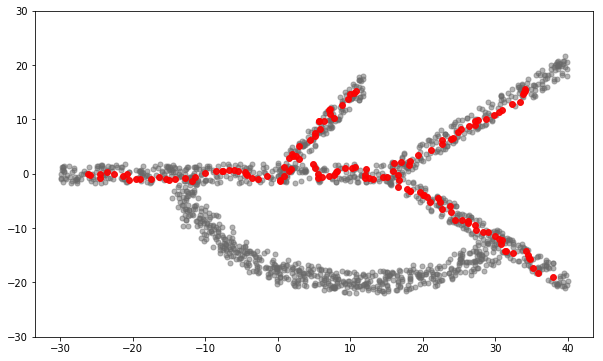

In [91]:
fig = plt.figure( figsize=(10,6))
ax1 = fig.add_subplot(111)
cc = "dimgrey"
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=35, c='red')
ax1.set_ylim(-30,30)

(-30, 30)

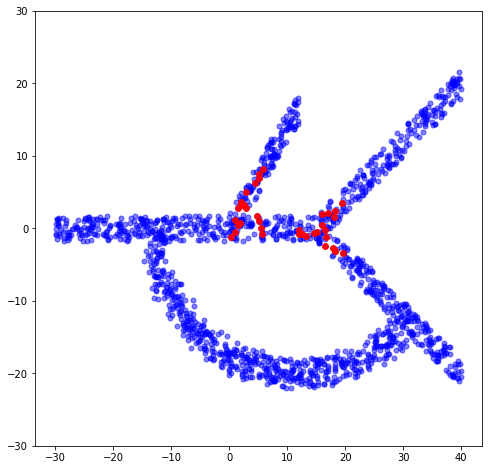

In [82]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = "blue"
ax1.scatter( down[:,0], down[:,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids[nn_ids],0], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)

In [83]:
# get graph distance matrix to bin data to nodes
g_dist = pcreode.get_graph_distance( np.arange( d_knn.vcount()), run_ind, d_knn)

In [84]:
# bin downsampled data points to each node
bin_id = np.argsort( g_dist, axis=1)[:,1]
len(bin_id), nn_ids

(1609, array([ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        102, 103, 104, 105, 106, 107, 138, 139, 140, 141, 142, 143]))

In [85]:
brch_bins = np.zeros_like( bin_id)
no_branch_ids = np.array( [], dtype=int)
for ii in nn_ids:
    brch_bins[np.argwhere( bin_id==ii).ravel()] = 1
no_branch_ids = np.argwhere(brch_bins==0).ravel()
nono_branch_ids = np.argwhere(brch_bins==1).ravel() 

no_branch_ids

array([   0,    1,    2, ..., 1606, 1607, 1608])

(-30, 30)

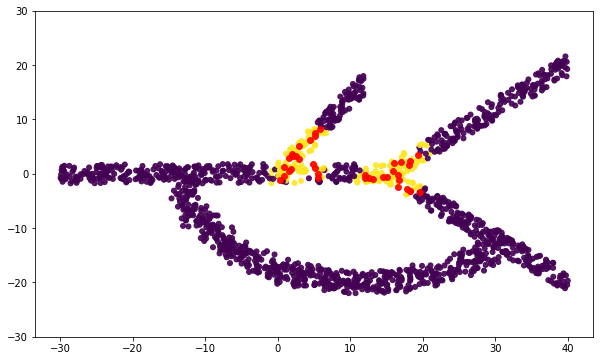

In [106]:
fig = plt.figure( figsize=(10,6))
ax1 = fig.add_subplot(111)
cc = brch_bins
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[out_ids[nn_ids],0], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)

In [87]:
no_branch_data = data[down_ind[no_branch_ids],:]

In [88]:
# create new knn graphs with branching data points removed
# set upper and lower thresholds for number of neighbors to connect in density 
# based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
upper_nn = 25
lower_nn = 2

# need to recalculate the density of no_branch_data
br_dens = pcreode.Density( no_branch_data)
br_density = br_dens.get_density( radius=0.80)

calculating densities for datapoints: 0 -> 1376
****Always check density overlay for radius fit****


(-30, 30)

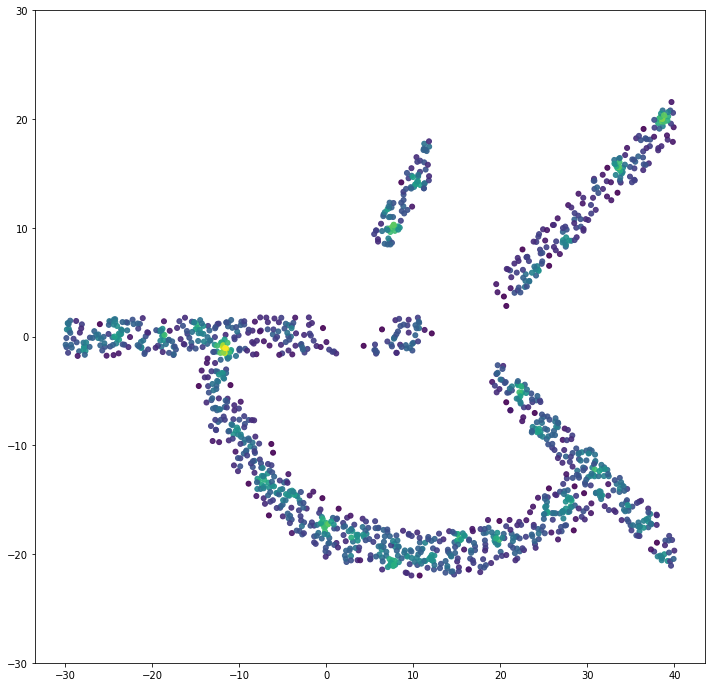

In [94]:
fig = plt.figure( figsize=(12,12))
ax1 = fig.add_subplot(111)
cc = br_density
ax1.scatter( no_branch_data[:,0], no_branch_data[:,1], alpha=0.9, s=25, c=cc)
ax1.set_ylim(-30,30)

In [95]:
# assign number of neighbors to connect to, to each datapoint 
br_sorted_nn = np.linspace( lower_nn, upper_nn, len( no_branch_data), dtype=int)
br_nn = np.zeros_like( br_density)
br_nn[np.argsort( br_density)] = br_sorted_nn

# create adjacency matrix to hold neighbor connections for d-kNN
br_knn_adj = np.zeros( ( len( br_density), len( br_density)), dtype=int)
br_dist = pairwise_distances( no_branch_data, no_branch_data)
for zz in range( len( br_density)):
    br_knn_adj[zz,np.argsort( br_dist[zz,:])[1:br_nn[zz]]] = 1
# to make symetric add adj with transpose
br_knn_adj = np.add( br_knn_adj, br_knn_adj.T)
br_knn_adj[br_knn_adj>0] = 1.0
br_dist_weighted_adj = np.multiply( br_dist, br_knn_adj)
brd_knn = _igraph.Graph.Weighted_Adjacency( br_dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

In [96]:
comps = np.array( brd_knn.components())

In [97]:
cocl = np.zeros_like( br_density)
for ii in range( len( comps)):
    cocl[comps[ii]] = ii * 10

In [98]:
br_ends = np.zeros_like( cen_ind)
for ii, cen_itr in enumerate( cen_ind):
    br_ends[ii] = pcreode.find_closest_ind( point=data[down_ind[cen_itr]], data=no_branch_data)
br_ends

array([1359,  770, 1114, 1103])

(-30, 30)

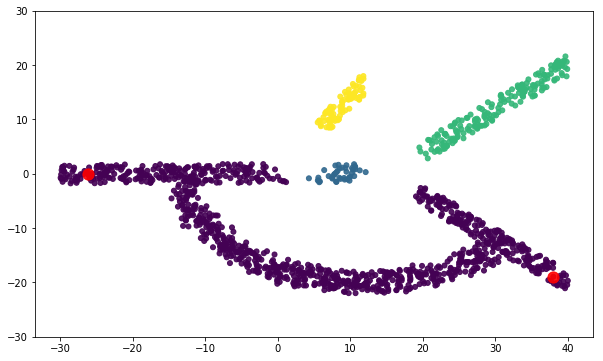

In [104]:
fig = plt.figure( figsize=(10,6))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( no_branch_data[:,0],       no_branch_data[:,1],       alpha=0.9, s=25,  c=cc)
ax1.scatter( no_branch_data[br_ends[1:4:2],0], no_branch_data[br_ends[1:4:2],1], alpha=0.9, s=125, c='r')
ax1.set_ylim(-30,30)

In [37]:
comp_adj = dens_adj.copy()
# remove all branching data point edges
comp_adj[nono_branch_ids,:] = 0
comp_adj[:,nono_branch_ids] = 0

#comp_adj = np.delete( comp_adj, nono_branch_ids, axis=0)
#comp_adj = np.delete( comp_adj, nono_branch_ids, axis=1)

for cc in range( len( comps)):
    if( sum(xx in comps[cc] for xx in br_ends)<=1):
        comp_adj[no_branch_ids[comps[cc]],:] = 0
        comp_adj[:,no_branch_ids[comps[cc]]] = 0
    else:
        print "yes"
        
len( np.nonzero( comp_adj)[0])

yes


13376

In [38]:
comp_knn = _igraph.Graph.Weighted_Adjacency( comp_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

In [39]:
#print comp_knn.components()
comps = np.array( comp_knn.components())
cocl = np.zeros_like( down_ind)

cocl[comps[0]] = 1 

In [40]:
cen_ind

array([1579,  815, 1225, 1211])

In [41]:
run_ind

array([1579,  815, 1225, 1211,  950,  761,  826,  840,  930,  774,  754,
        704,  795,  601,  646,  937,  707,  856,    5,    7,    2,  823,
        732,  712,  787,  591,  954,  653,  734,  828,  687,  898,  735,
        865,  836, 1531, 1490, 1518, 1576, 1517, 1560, 1578, 1512, 1586,
       1472, 1536, 1605, 1572, 1481, 1456, 1595, 1516, 1569, 1583, 1567,
       1485, 1511, 1471, 1543, 1596, 1268, 1236, 1375, 1244, 1310, 1305,
       1219, 1309, 1258, 1267, 1290, 1257, 1356, 1243, 1308, 1357, 1440,
       1367, 1430, 1271, 1324, 1370, 1326, 1289, 1216, 1380,  999, 1158,
        662,  661,  952,  819,  958,  883,  744,  884,  776,  955,  947,
        814,  864,  845,  882,  607,  944,  616, 1574, 1585, 1119, 1207,
       1060, 1088, 1005, 1184, 1012, 1175, 1161,  970, 1134,  993, 1003,
        980, 1051, 1093,  978, 1058, 1137, 1151, 1124, 1085, 1027,  998,
        988, 1053, 1033, 1052,  994, 1154, 1208, 1172, 1165, 1178, 1043,
       1152])

In [42]:
comp_ends = hi_pl_ind[np.isin( hi_pl_ind, comps[0])]
comp_ends

array([ 815, 1211,  895,  827,  653,  954,  712,  732,  823,  767,    7,
          5,  856,  937,  646,  601,  795,  704,  753,  692,  637,  761,
        950, 1119, 1207,  962, 1117, 1012, 1175, 1118, 1018,  976, 1051,
        978, 1104, 1151, 1194, 1085, 1010, 1053])

In [43]:
alt_rte, alt_ind = pcreode.hierarchical_placement( comp_knn, comp_ends)

(-30, 30)

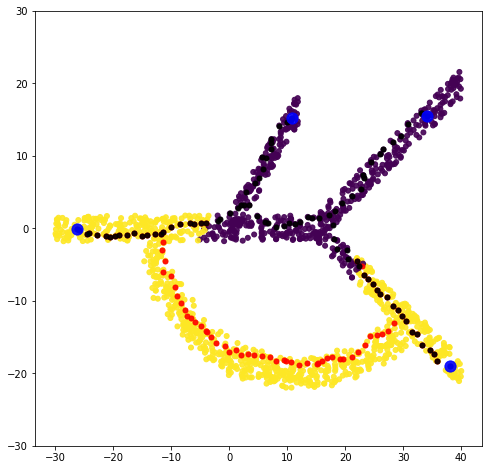

In [44]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[down_ind[alt_ind],0], data[down_ind[alt_ind],1], alpha=0.9, s=25, c='r')
ax1.scatter( data[down_ind[hi_pl_ind],0], data[down_ind[hi_pl_ind],1], alpha=0.9, s=25, c='black')
ax1.scatter( data[down_ind[cen_ind],0], data[down_ind[cen_ind],1], alpha=0.9, s=125, c='blue')
ax1.set_ylim(-30,30)

In [45]:
# combine alternate route graph and pcreode graph node indices, downsampled indices
all_inds = np.unique( np.append( hi_pl_ind, alt_ind))

In [46]:
# run consensus alignment on combined alternate route and pcreode graph
all_aligned_ind = pcreode.consensus_alignment( data[down_ind], all_inds.copy(), data, density, noise)
all_aligned_ind

array([   6,   22,   48,   59,   69,   82,   88,   91,   97,  106,  134,
        136,  143,  156,  181,  184,  194,  207,  208,  212,  251,  254,
        268,  286,  294,  299,  323,  343,  361,  369,  371,  395,  415,
        423,  424,  440,  442,  448,  471,  484,  487,  497,  518,  526,
        541,  548,  588,  608,  625,  631,  634,  653,  669,  674,  678,
        706,  707,  711,  712,  714,  720,  740,  742,  752,  761,  764,
        770,  776,  780,  798,  803,  816,  853,  854,  869,  882,  918,
        945,  947,  998, 1004, 1008, 1013, 1022, 1025, 1026, 1032, 1035,
       1048, 1052, 1071, 1081, 1091, 1106, 1118, 1132, 1142, 1146, 1151,
       1171, 1175, 1187, 1205, 1209, 1264, 1265, 1266, 1273, 1274, 1278,
       1304, 1328, 1329, 1346, 1357, 1359, 1370, 1380, 1392, 1427, 1432,
       1442, 1460, 1483, 1485, 1486, 1490, 1501, 1505, 1511, 1515, 1526,
       1541, 1544, 1556, 1564, 1579, 1585, 1592, 1595])

In [47]:
# add orginal endstates back into aligned list of indices 
all_es_ind = np.append( cen_ind, np.unique( all_aligned_ind[~np.in1d( all_aligned_ind, cen_ind)]))
cen_ind, all_es_ind

(array([1579,  815, 1225, 1211]),
 array([1579,  815, 1225, 1211,    6,   22,   48,   59,   69,   82,   88,
          91,   97,  106,  134,  136,  143,  156,  181,  184,  194,  207,
         208,  212,  251,  254,  268,  286,  294,  299,  323,  343,  361,
         369,  371,  395,  415,  423,  424,  440,  442,  448,  471,  484,
         487,  497,  518,  526,  541,  548,  588,  608,  625,  631,  634,
         653,  669,  674,  678,  706,  707,  711,  712,  714,  720,  740,
         742,  752,  761,  764,  770,  776,  780,  798,  803,  816,  853,
         854,  869,  882,  918,  945,  947,  998, 1004, 1008, 1013, 1022,
        1025, 1026, 1032, 1035, 1048, 1052, 1071, 1081, 1091, 1106, 1118,
        1132, 1142, 1146, 1151, 1171, 1175, 1187, 1205, 1209, 1264, 1265,
        1266, 1273, 1274, 1278, 1304, 1328, 1329, 1346, 1357, 1359, 1370,
        1380, 1392, 1427, 1432, 1442, 1460, 1483, 1485, 1486, 1490, 1501,
        1505, 1511, 1515, 1526, 1541, 1544, 1556, 1564, 1585, 1592, 1595]))

In [48]:
# perform hierarchical placement of newly aligned data points
all_hi_pl, all_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, all_es_ind)

In [49]:
# hierarchical placement assumes there are no loops therefore only tests for 
# one complete graph component, so the loop needs to be connected at both ends
# only one end connected at this point.
# the missing connection will be the greatest difference between graph distance and 
# euclidean distance

# get graph distance for all nodes
graph_dist = pcreode.get_graph_distance( range( len( all_hi_pl_ind)), range( len( all_hi_pl_ind)), all_hi_pl)
# euclidean distance
euc_dist = pairwise_distances( data[down_ind[all_hi_pl_ind]], data[down_ind[all_hi_pl_ind]]) 

In [50]:
# find the maximum difference in distances 
loose_ends = np.unravel_index( np.argmax( np.subtract( graph_dist, euc_dist)), graph_dist.shape, order='C')
loose_ends[::-1]

(87, 49)

In [51]:
# get adjacency matrix
start_adj = np.array( all_hi_pl.get_adjacency(type=GET_ADJACENCY_BOTH).data)
start_adj.shape, start_adj[loose_ends]
start_adj

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [52]:
# connect the loose ends
start_adj[loose_ends] = 1
start_adj[loose_ends[::-1]] = 1
start_adj[loose_ends[0],loose_ends[1]]

1

In [53]:
alter_nodes = down_ind[all_hi_pl_ind]

(-30, 30)

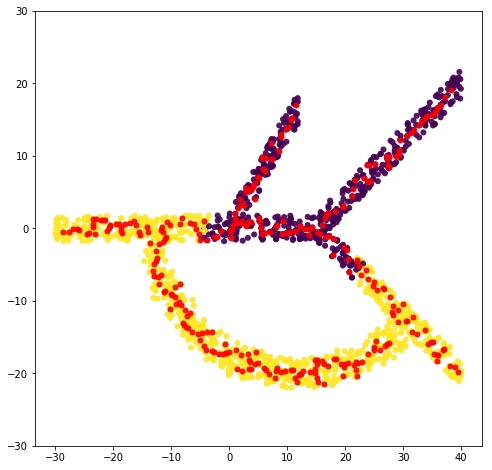

In [54]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[alter_nodes,0], data[alter_nodes,1], alpha=0.9, s=25, c='r')
ax1.set_ylim(-30,30)

In [55]:
# now the unwanted endstates need to be removed
# these should sum to 1, so we iter through and remove until 
# we only have our original endstates 
ends = range( len(cen_ind))
sum1 = np.argwhere( np.sum( start_adj, axis=0)==1).flatten()
# placeholder for nodes to keep after triming
itr_inds = alter_nodes

while( ~np.alltrue( np.isin( sum1, ends))):
    
    # find all nodes with degree of 1, eg the ends
    sum1 = np.argwhere( np.sum( start_adj, axis=0)==1).flatten()
    # keep only the ones that are not flagged by pcreode as endstates
    sum1_notends = sum1[~np.isin( sum1, ends)]
    # delete the unwanted end nodes
    start_adj = np.delete( start_adj, sum1_notends, axis=0)
    start_adj = np.delete( start_adj, sum1_notends, axis=1)
    # keep track of which of the data nodes we are keeping
    itr_inds = np.delete(  itr_inds,  sum1_notends)
    start_adj.shape

(-30, 30)

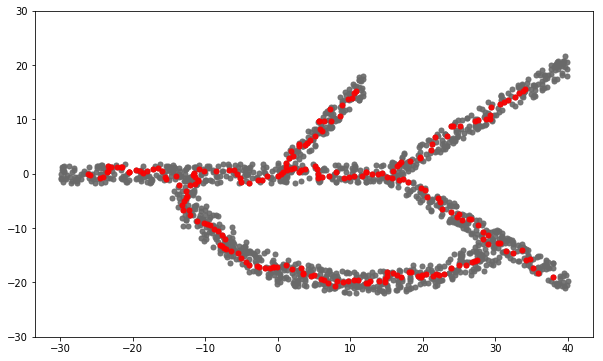

In [105]:
fig = plt.figure( figsize=(10,6))
ax1 = fig.add_subplot(111)
cc = 'dimgrey'
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[itr_inds,0], data[itr_inds,1], alpha=0.9, s=25, c='r')
ax1.set_ylim(-30,30)

In [57]:
np.savetxt( file_path + "ind_{0}.csv".format( 0), itr_inds,  delimiter=',')
np.savetxt( file_path + "adj_{0}.txt".format( 0), start_adj, delimiter=' ')

In [58]:
gid = 0
analysis = pcreode.Analysis( file_path=file_path, graph_id=gid, data=data, density=density, noise=noise)

In [59]:
seed = 0

In [60]:
seed = seed + 1
seed

1

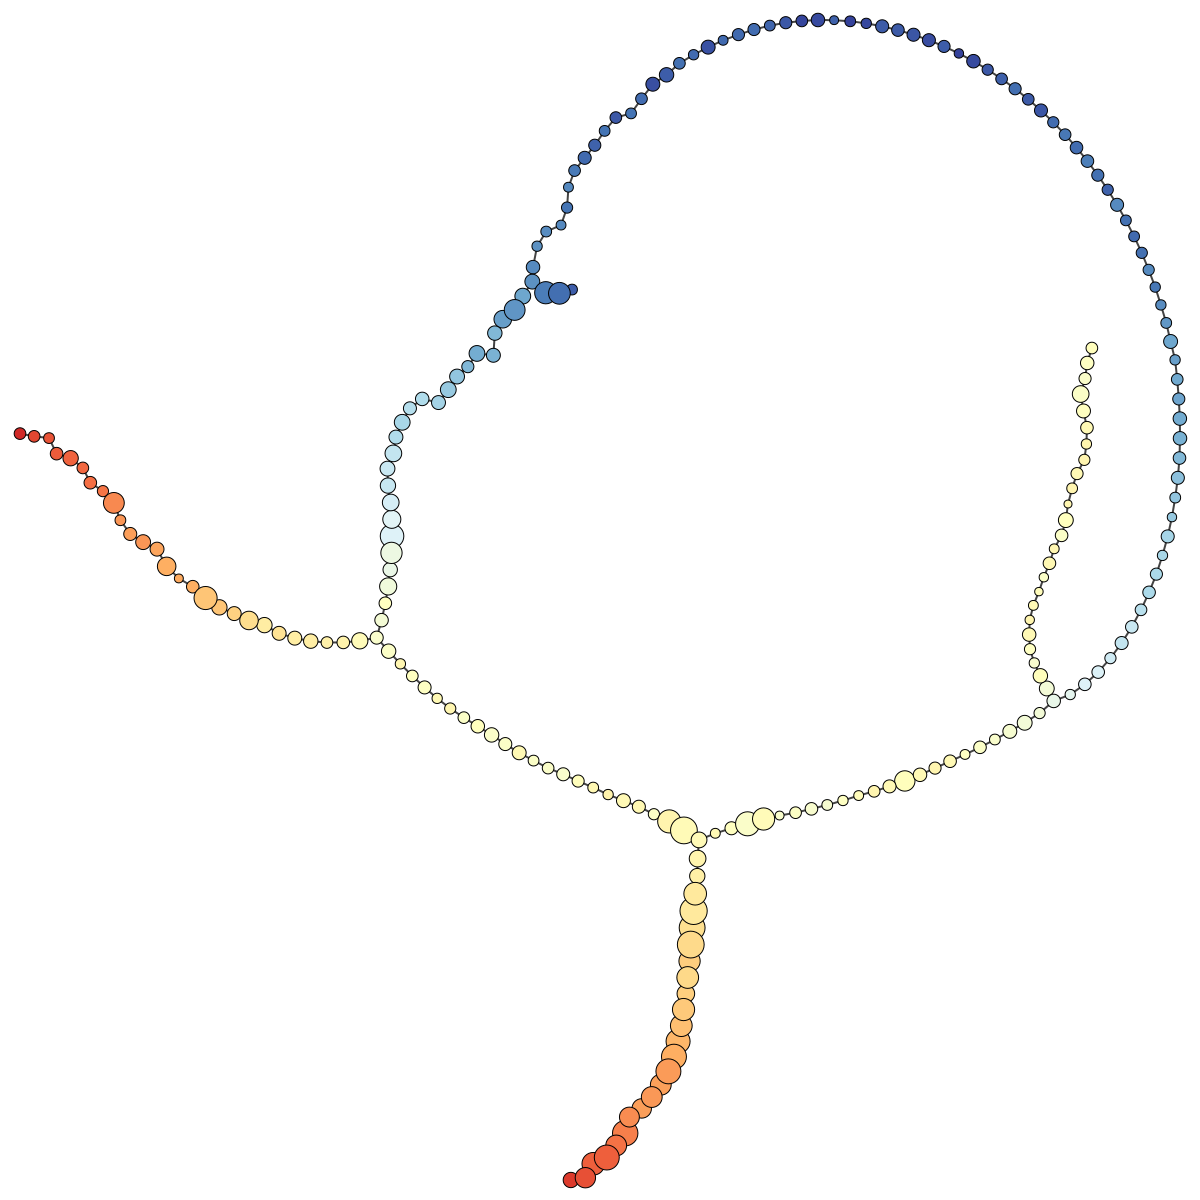

In [62]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(data[:,1]), file_out='x', upper_range=1.0)

In [ ]:
start_g = _igraph.Graph.Weighted_Adjacency( start_adj.tolist(), mode=ADJ_UNDIRECTED)

In [ ]:
layout = start_g.layout_mds( dist=pairwise_distances( data[itr_inds], data[itr_inds]))

In [ ]:
plot( start_g, layout=layout)